## Introduction:

To infect cells and reproduce successfully, viruses must influence the behaviour of their hosts to successfully spread and copy their genomes. At the most basic level, this happens in an infected cell,  where a virus affects the expression and regulation of host genes. A virus may want to interrupt genes related to antiviral immunity, change the regulation of normal cellular metabolism, or even disrupt the signalling between cells to obscure their presence in the host.

RNA viruses have an amazingly diverse toolbox of molecular tricks that they can play on their host cells given the small size of their genomes. Often viral genes are multifunctional, encoding functions that are essential for their own replication and also antagonize the host in some way. Even the structure and replication of many viral genomes indicates shows the same selective pressure to develop this antagonistic multifunctionality. At every step of the replication process, viruses benefit from interferring and augmenting the normal cellular processes of their host.

Where viruses have developed a diverse toolbox to antagonize the cellular functions of their hosts, the host cells have also developed an equivalently multifunctional genetic toolbox to detect and interfere with viral replication. In mammalian cells, there are an estimated [f'{n}] number of immune genes that are activated in response to various viral infections. The ways that cells can restrict viral infections vary across species, but many differe 

## Methods:
Data was obtained from the SRA, accession numbers (......). Kmers were counted using a sliding window approach excluding any nucleotide symbols other than A, T, G, or C.

In [9]:
# Counting Kmers and joining with Metadata
from Bio import SeqIO
from collections import Counter, defaultdict
import pandas as pd
import os
import re
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Parameters
input_directory = "C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/high"
output_directory = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
kmer_range = range(1, 10)  # Range for k-mer
valid_chars = {"A", "T", "G", "C"}  # Set of valid nucleotide characters
label_file = "C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/metadata/multivirus_labels.csv"

# k-mer counting using collections.Counter
def count_kmers(sequence, k):
    return Counter(map(''.join, zip(*[sequence[i:] for i in range(k)])))

# Process a single file and count k-mers
def process_file(file_path, k):
    accession_kmer_counts = defaultdict(Counter)
    try:
        with open(file_path, 'r') as f:
            first_char = f.read(1)
            file_format = "fasta" if first_char == ">" else "fastq"

        for record in SeqIO.parse(file_path, file_format):
            header = record.id
            match = re.match(r"(SRR\d+)", header)  # Extract SRR accession number
            if match:
                accession = match.group(1)
                sequence = str(record.seq)
                kmer_counts = count_kmers(sequence, k)
                accession_kmer_counts[accession].update(kmer_counts)
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
    return accession_kmer_counts

# Process all files in the input directory
def process_files(input_directory, k):
    accession_kmer_counts = defaultdict(Counter)
    print(f"Processing {k}-mers for all .fastq files in {input_directory}...")

    file_paths = [os.path.join(input_directory, filename)
                  for filename in os.listdir(input_directory) if filename.endswith(".fastq")]

    for file_path in file_paths:
        result = process_file(file_path, k)
        for accession, kmer_counts in result.items():
            accession_kmer_counts[accession].update(kmer_counts)

    # Prepare the results for DataFrame
    output_results = []
    for accession, kmer_counts in accession_kmer_counts.items():
        filtered_kmer_counts = {
            kmer: count for kmer, count in kmer_counts.items()
            if set(kmer).issubset(valid_chars)
        }
        filtered_total_count = sum(filtered_kmer_counts.values())
        kmer_proportions = {
            kmer: count / filtered_total_count
            for kmer, count in filtered_kmer_counts.items()
        } if filtered_total_count > 0 else {}
        result = {"Accession": accession, **kmer_proportions}
        output_results.append(result)

    df = pd.DataFrame(output_results).fillna(0)

    # Merge with labels
    labels_df = pd.read_csv(label_file)
    merged_df = df.merge(labels_df[['Run', 'Virus', 'HPI']].rename(columns={'Run': 'Accession'}), on='Accession', how='left')

    return merged_df

# Main execution
if __name__ == "__main__":
    # Create cophenetic correlation file header

    for k in kmer_range:
        kmer_df = process_files(input_directory, k)
        output_file = os.path.join(output_directory, f"multivirus_{k}mer_results_high.csv")
        kmer_df.to_csv(output_file, index=True)
        print(f"Saved results for {k}-mers to {output_file}")



Processing 1-mers for all .fastq files in C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/high...
Saved results for 1-mers to C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\multivirus_1mer_results_high.csv
Processing 2-mers for all .fastq files in C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/high...
Saved results for 2-mers to C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\multivirus_2mer_results_high.csv
Processing 3-mers for all .fastq files in C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/high...
Saved results for 3-mers to C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\multivirus_3mer_results_high.csv
Processing 4-mers for all .fastq files in C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/high...
Saved results for 4-mers to C:/Users

In [4]:
# Shuffle nucleotides within each read in the .fastq files
import os
import random
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def shuffle_fastq_sequences(input_path, output_path):
    shuffled_records = []

    for record in SeqIO.parse(input_path, "fastq"):
        seq_list = list(str(record.seq))
        random.shuffle(seq_list)
        shuffled_seq = ''.join(seq_list)

        shuffled_record = SeqRecord(
            Seq(shuffled_seq),
            id=record.id,
            description=record.description,
            letter_annotations={"phred_quality": record.letter_annotations["phred_quality"]}
        )
        shuffled_records.append(shuffled_record)

    SeqIO.write(shuffled_records, output_path, "fastq")
    print(f" Shuffled written: {output_path}")

def shuffle_all_fastqs(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for filename in os.listdir(input_dir):
        if filename.endswith(".fastq"):
            input_path = os.path.join(input_dir, filename)
            base, ext = os.path.splitext(filename)
            output_path = os.path.join(output_dir, f"{base}_shuffled{ext}")
            shuffle_fastq_sequences(input_path, output_path)

# Example usage
input_directory = "C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered"
output_directory = input_directory + "_shuffled"

shuffle_all_fastqs(input_directory, output_directory)


✅ Shuffled written: C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered_shuffled\SRR27926886_shuffled.fastq
✅ Shuffled written: C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered_shuffled\SRR27926887_shuffled.fastq
✅ Shuffled written: C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered_shuffled\SRR27926888_shuffled.fastq
✅ Shuffled written: C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered_shuffled\SRR27926889_shuffled.fastq
✅ Shuffled written: C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered_shuffled\SRR27926890_shuffled.fastq
✅ Shuffled written: C:/Users/DIR/OneDrive - Cornell University/One Drive Jupyter/multivirus-classification/data/unfiltered_shuffled\SRR27926891_shuffled.fastq
✅ Shuffled written: C:/Users/DIR/OneDrive - Co

In [10]:
# Label permutation shuffling
import os
import pandas as pd

def permute_labels(input_csv, output_csv, label_col="Virus", random_state=42):
    df = pd.read_csv(input_csv)

    if label_col not in df.columns:
        print(f"Skipping {input_csv}: '{label_col}' column not found.")
        return

    shuffled_labels = df[label_col].sample(frac=1, random_state=random_state).reset_index(drop=True)
    df[label_col] = shuffled_labels
    df.to_csv(output_csv, index=False)
    print(f"Wrote: {output_csv}")

def permute_labels_in_directory(input_dir, label_col="Virus", suffix="_label_permuted", pattern_filter="results"):
    for filename in os.listdir(input_dir):
        if filename.endswith(".csv") and pattern_filter in filename:
            input_path = os.path.join(input_dir, filename)
            output_filename = filename.replace(".csv", f"{suffix}.csv")
            output_path = os.path.join(input_dir, output_filename)
            permute_labels(input_path, output_path, label_col=label_col)

# === Example usage ===
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels"
permute_labels_in_directory(kmer_csv_dir)



Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_1mer_results_unfiltered_label_permuted.csv
Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_2mer_results_unfiltered_label_permuted.csv
Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_3mer_results_unfiltered_label_permuted.csv
Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_4mer_results_unfiltered_label_permuted.csv
Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_5mer_results_unfiltered_label_permuted.csv
Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_6mer_results_unfiltered_label_permuted.csv
Wrote: C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/permuted-labels\multivirus_7mer_re

In [ ]:
# Get  stats for unfiltered data
import os
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

# === Parameters ===
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
bootstrap_iterations = 100
bootstrap_fraction = 0.8
output_file = os.path.join(kmer_csv_dir, "dendrogram_bootstrap_purity_stats.csv")

# === Function to calculate per-class purities ===
def compute_class_purities(linkage_matrix, labels):
    tree, _ = to_tree(linkage_matrix, rd=True)
    id_to_label = {i: labels[i] for i in range(len(labels))}
    label_to_indices = defaultdict(list)
    for i, label in enumerate(labels):
        label_to_indices[label].append(i)

    class_purities = {}
    for label, indices in label_to_indices.items():
        indices_set = set(indices)

        def find_subtree(node):
            if node.is_leaf():
                return node if node.id in indices_set else None
            left = find_subtree(node.left)
            right = find_subtree(node.right)
            if left and right:
                return node
            return left or right

        subtree = find_subtree(tree)
        if subtree:
            leaf_ids = subtree.pre_order()
            labels_in_subtree = [id_to_label[i] for i in leaf_ids]
            count = Counter(labels_in_subtree)
            correct = count[label]
            total = len(leaf_ids)
            purity = correct / total if total > 0 else 0.0
            class_purities[label] = purity
        else:
            class_purities[label] = 0.0

    return class_purities

# === Load CSVs and process ===
csv_files = [f for f in sorted(os.listdir(kmer_csv_dir)) if f.endswith("_results_unfiltered.csv")]
bootstrap_results = []

for filename in csv_files:
    file_path = os.path.join(kmer_csv_dir, filename)
    df = pd.read_csv(file_path)

    if "Virus" not in df.columns:
        continue

    k_match = [c for c in filename if c.isdigit()]
    k = ''.join(k_match) if k_match else '?'

    excluded_columns = ["Accession", "Filter", "Virus"]
    feature_cols = [col for col in df.columns if col not in excluded_columns]
    if df.shape[0] < 5:
        print(f"Skipping {filename}: not enough samples")
        continue

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[feature_cols].values)

    for iteration in range(bootstrap_iterations):
        sample_size = int(bootstrap_fraction * scaled_data.shape[0])
        if sample_size < 3:
            continue

        sample_indices = np.random.choice(scaled_data.shape[0], size=sample_size, replace=False)
        sample_data = scaled_data[sample_indices]
        sample_labels = df["Virus"].values[sample_indices]

        try:
            dist_matrix = pdist(sample_data)
            linkage_matrix = linkage(sample_data, method='ward')
            max_height = np.max(linkage_matrix[:, 2])

            class_purities = compute_class_purities(linkage_matrix, sample_labels)
            mean_purity = np.mean(list(class_purities.values()))

            result = {
                "k": k,
                "Filename": filename,
                "Iteration": iteration + 1,
                "Num_Samples": sample_data.shape[0],
                "Num_Kmers": scaled_data.shape[1],
                "Mean_Purity": round(mean_purity, 4),
                "Tree_Max_Height": round(max_height, 4)
            }
            for strain, purity in class_purities.items():
                result[f"Purity_{strain}"] = round(purity, 4)

            bootstrap_results.append(result)

        except Exception as e:
            print(f"Iteration {iteration} failed for {filename}: {e}")
            continue

# === Save results ===
bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df.to_csv(output_file, index=False)


In [ ]:
# Get  stats for virally depleted data
import os
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler

# === Parameters ===
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
bootstrap_iterations = 100
bootstrap_fraction = 0.8
output_file = os.path.join(kmer_csv_dir, "dendrogram_bootstrap_purity_stats_high.csv")

# === Function to calculate per-class purities ===
def compute_class_purities(linkage_matrix, labels):
    tree, _ = to_tree(linkage_matrix, rd=True)
    id_to_label = {i: labels[i] for i in range(len(labels))}
    label_to_indices = defaultdict(list)
    for i, label in enumerate(labels):
        label_to_indices[label].append(i)

    class_purities = {}
    for label, indices in label_to_indices.items():
        indices_set = set(indices)

        def find_subtree(node):
            if node.is_leaf():
                return node if node.id in indices_set else None
            left = find_subtree(node.left)
            right = find_subtree(node.right)
            if left and right:
                return node
            return left or right

        subtree = find_subtree(tree)
        if subtree:
            leaf_ids = subtree.pre_order()
            labels_in_subtree = [id_to_label[i] for i in leaf_ids]
            count = Counter(labels_in_subtree)
            correct = count[label]
            total = len(leaf_ids)
            purity = correct / total if total > 0 else 0.0
            class_purities[label] = purity
        else:
            class_purities[label] = 0.0

    return class_purities

# === Load CSVs and process ===
csv_files = [f for f in sorted(os.listdir(kmer_csv_dir)) if f.endswith("_results_high.csv")]
bootstrap_results = []

for filename in csv_files:
    file_path = os.path.join(kmer_csv_dir, filename)
    df = pd.read_csv(file_path)

    if "Virus" not in df.columns:
        continue

    k_match = [c for c in filename if c.isdigit()]
    k = ''.join(k_match) if k_match else '?'

    excluded_columns = ["Accession", "Filter", "Virus"]
    feature_cols = [col for col in df.columns if col not in excluded_columns]
    if df.shape[0] < 5:
        print(f"Skipping {filename}: not enough samples")
        continue

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[feature_cols].values)

    for iteration in range(bootstrap_iterations):
        sample_size = int(bootstrap_fraction * scaled_data.shape[0])
        if sample_size < 3:
            continue

        sample_indices = np.random.choice(scaled_data.shape[0], size=sample_size, replace=False)
        sample_data = scaled_data[sample_indices]
        sample_labels = df["Virus"].values[sample_indices]

        try:
            dist_matrix = pdist(sample_data)
            linkage_matrix = linkage(sample_data, method='ward')
            max_height = np.max(linkage_matrix[:, 2])

            class_purities = compute_class_purities(linkage_matrix, sample_labels)
            mean_purity = np.mean(list(class_purities.values()))

            result = {
                "k": k,
                "Filename": filename,
                "Iteration": iteration + 1,
                "Num_Samples": sample_data.shape[0],
                "Num_Kmers": scaled_data.shape[1],
                "Mean_Purity": round(mean_purity, 4),
                "Tree_Max_Height": round(max_height, 4)
            }
            for strain, purity in class_purities.items():
                result[f"Purity_{strain}"] = round(purity, 4)

            bootstrap_results.append(result)

        except Exception as e:
            print(f"Iteration {iteration} failed for {filename}: {e}")
            continue

# === Save results ===
bootstrap_df = pd.DataFrame(bootstrap_results)
bootstrap_df.to_csv(output_file, index=False)


✅ Saved model with features to C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\rf_combined_kmers_unfiltered.pkl


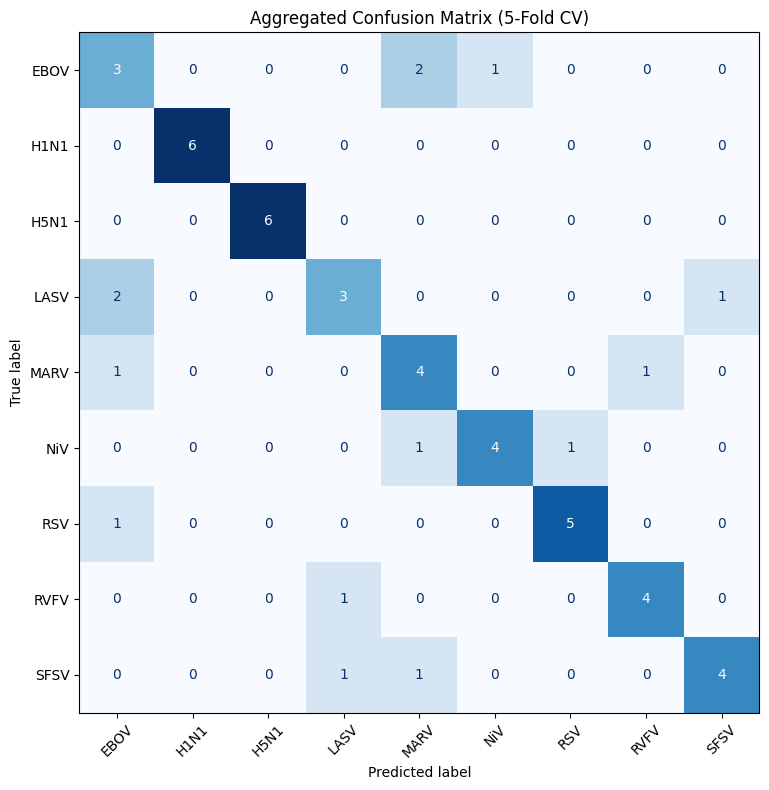

In [27]:
# Generating Model for Web App
## This model uses all kmer lengths and combines them into a single data frame, using all kmers in the range as features
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === PARAMETERS ===
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
k_range = range(1, 6)
model_output_path = os.path.join(kmer_csv_dir, "rf_combined_kmers_unfiltered.pkl")

# === Load and combine data ===
dfs = []
for k in k_range:
    path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_unfiltered.csv")
    if not os.path.exists(path):
        print(f"Skipping missing file: {path}")
        continue
    df = pd.read_csv(path)
    df = df[
        (df["Virus"] != "Mock") &
        (~df["HPI"].isin([3]))
    ]
    df = df.drop(columns=["Accession"])
    df = df.set_index(["Virus", "HPI"])
    dfs.append(df)

combined = pd.concat(dfs, axis=1)
combined = combined.reset_index()
combined = combined.dropna()

# Find all columns that are valid kmer features
kmer_feature_cols = [col for col in combined.columns if (
    isinstance(col, str) and  # Make sure column is a string
    set(col).issubset({'A', 'T', 'G', 'C'}) and  # Only ATGC in the column name
    len(col) >= 1  # At least length 1 (could adjust if needed)
)]

X = combined[kmer_feature_cols]  # ONLY kmers
y = combined["Virus"].values
class_labels = np.unique(y)

# === Scale features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train Random Forest and Save ===
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_scaled, y)

model_bundle = {
    "model": rf,
    "scaler": scaler,
    "feature_names": X.columns.tolist()
}
joblib.dump(model_bundle, model_output_path)
print(f"Saved model with features to {model_output_path}")

# === K-Fold Cross-Validation for Confusion Matrix ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
agg_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)
all_true = []
all_pred = []

for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    agg_cm += cm
    all_true.extend(y_test)
    all_pred.extend(y_pred)

# === Plot aggregated Confusion Matrix ===
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=agg_cm, display_labels=class_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
ax.set_title("Aggregated Confusion Matrix (5-Fold CV)")
plt.tight_layout()
plt.show()


In [30]:
# Gradio app for predicting virus class from a nucleotide sequence using saved RF model

import gradio as gr
import pandas as pd
import numpy as np
import joblib
from collections import Counter
from itertools import product
from sklearn.preprocessing import StandardScaler

# === PARAMETERS ===
kmer_model_path = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables/rf_combined_kmers_unfiltered.pkl"

# === Load trained model and scaler ===
model_bundle = joblib.load(kmer_model_path)
rf_model = model_bundle["model"]
scaler = model_bundle["scaler"]
expected_kmers = model_bundle["feature_names"]  # List of k-mers used during training

# === Count kmers in a sequence ===
def count_kmers(sequence, k):
    sequence = sequence.upper()
    counts = Counter()
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if set(kmer).issubset({'A', 'T', 'G', 'C'}):
            counts[kmer] += 1
    return counts

# === Construct feature vector from nucleotide string ===
def sequence_to_kmer_features(sequence):
    sequence = sequence.upper()
    all_counts = Counter()

    # Dynamically determine which k-lengths are in the feature set
    unique_k_lengths = sorted(set(len(kmer) for kmer in expected_kmers))
    for k in unique_k_lengths:
        all_counts.update(count_kmers(sequence, k))

    total = sum(all_counts.values())
    proportions = {kmer: all_counts.get(kmer, 0) / total if total > 0 else 0 for kmer in expected_kmers}

    return pd.DataFrame([proportions])

# === Prediction function ===
def predict_virus(sequence):
    if not sequence:
        return "No sequence provided", None

    # Generate feature DataFrame
    features = sequence_to_kmer_features(sequence)

    # Make sure columns are exactly in expected order
    features = features[expected_kmers]  # This reorders and guarantees alignment

    # Scale
    features_scaled = scaler.transform(features)

    # Predict
    prediction = rf_model.predict(features_scaled)[0]
    probas = rf_model.predict_proba(features_scaled)[0]
    class_labels = rf_model.classes_

    # Format probabilities
    proba_df = pd.DataFrame({
        "Virus": class_labels,
        "Probability": probas
    }).sort_values("Probability", ascending=False)

    return f"Predicted Virus: {prediction}", proba_df

# === Gradio Interface ===
input_text = gr.Textbox(lines=10, label="Paste a nucleotide sequence (A/T/G/C only)")
output_text = gr.Label(label="Prediction")
output_table = gr.Dataframe(label="Prediction Probabilities")

iface = gr.Interface(
    fn=predict_virus,
    inputs=input_text,
    outputs=[output_text, output_table],
    title="Virus Class Predictor",
    description="Enter a nucleotide sequence to predict the virus class using a trained Random Forest model."
)

iface.launch(inline=False)  # Use iface.launch() if outside Jupyter


* Running on local URL:  http://127.0.0.1:7871

To create a public link, set `share=True` in `launch()`.


## Results:
The host cell response to a viral infection is specific enough to distinguish the type of virus that is present.
   Using a publicly available microarray expression dataset, hierarchical clustering was performed to  

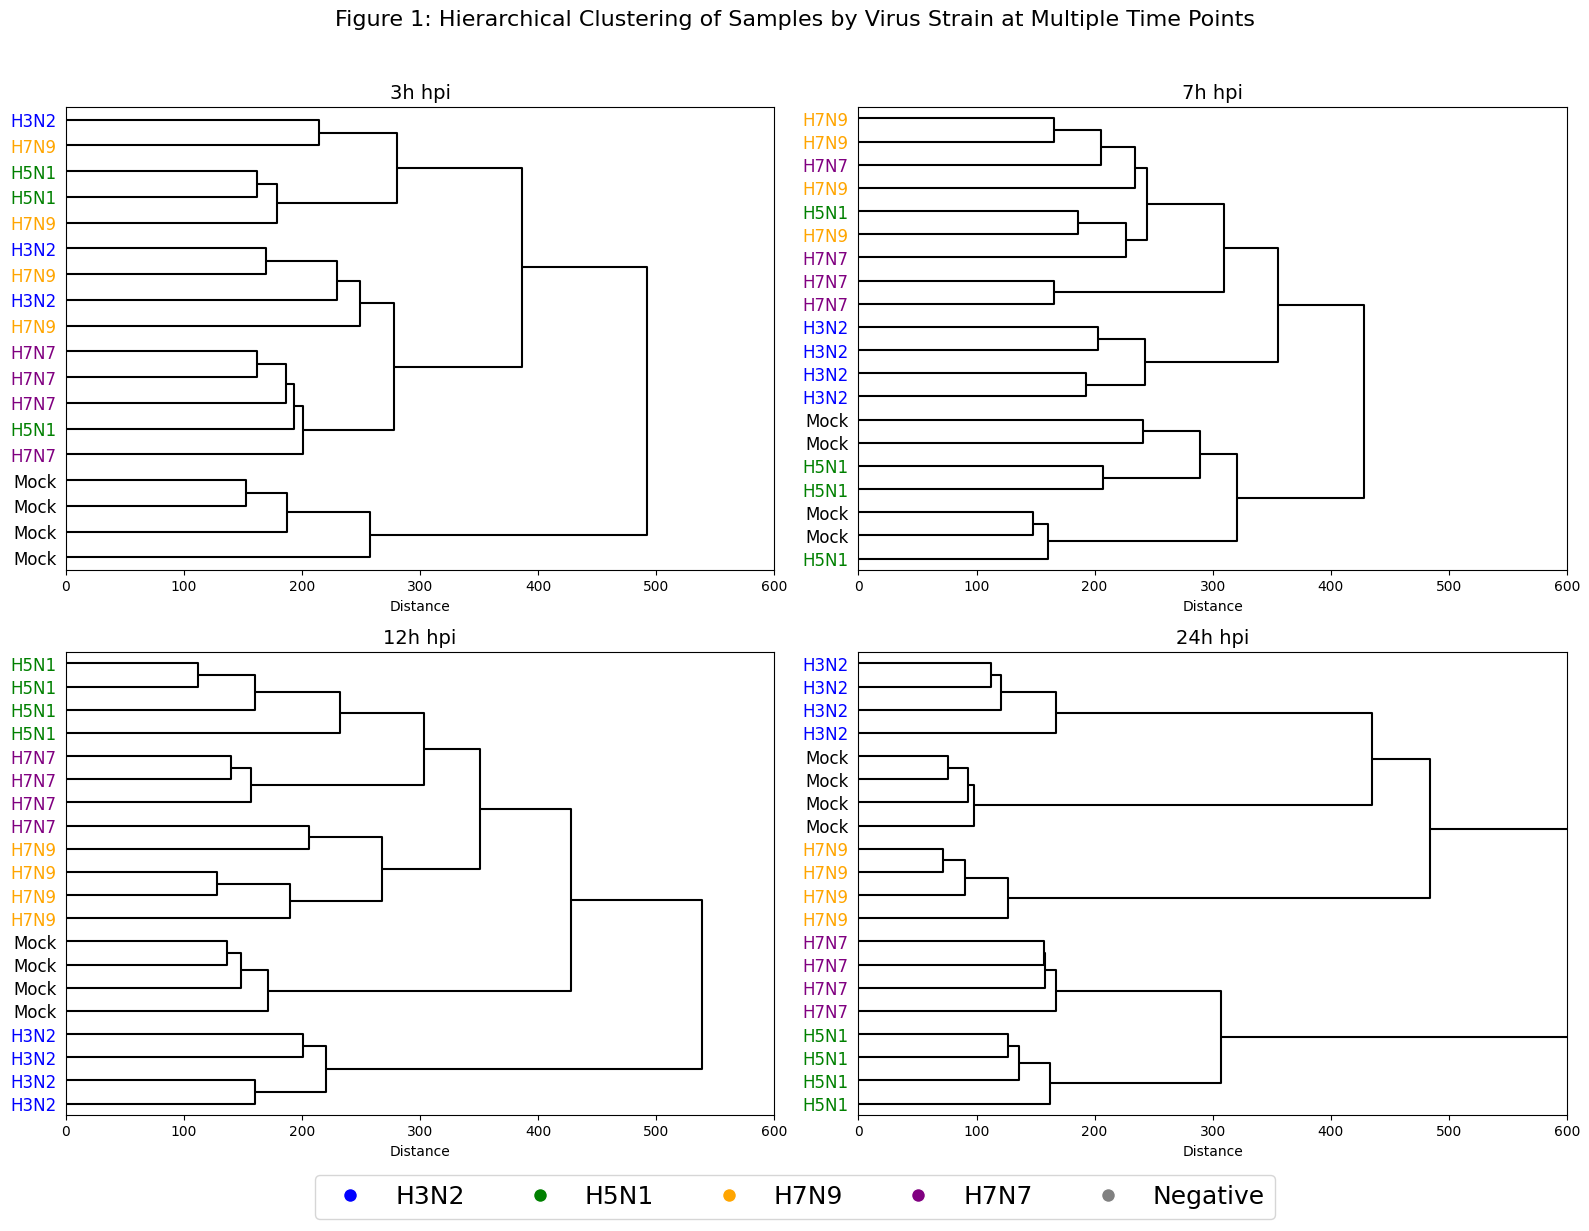

In [5]:
# Figure 1: Hierarchical Classification of Influenza Virus based on Microarray Gene Expression 
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler

# === Load data ===
df = pd.read_csv("C:/Users/DIR/Jupyter/Multi-strain classification/dataset-1/data.csv")

strain_to_color = {
    'H3N2': 'blue',
    'H5N1': 'green',
    'H7N9': 'orange',
    'H7N7': 'purple',
    'Negative': 'gray',
}    

# === Explicit max distance for all panels ===
global_max_distance = 600  # <--- set this to a fixed value based on your needs

# === Setup figure ===
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

ordered_timepoints = ["3h", "7h", "12h", "24h"]  # Make sure these match your dataset exactly

for i, timepoint in enumerate(ordered_timepoints):
    subset = df[df["Time"] == timepoint]
    if subset.shape[0] < 2:
        axs[i].set_visible(False)
        continue

    expression_data = subset.iloc[:, 1:-2]
    labels = subset["Virus_Strain"].values
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(expression_data)
    linkage_matrix = linkage(scaled_data, method='ward')

    dendrogram(
        linkage_matrix,
        labels=labels,
        orientation='right',
        leaf_font_size=12,
        leaf_rotation=0,
        ax=axs[i],
        color_threshold=0,
        link_color_func=lambda k: 'black',
    )

    # Color the strain labels
    for lbl in axs[i].get_ymajorticklabels():
        strain = lbl.get_text()
        lbl.set_color(strain_to_color.get(strain, 'black'))
        lbl.set_fontsize(12)

    axs[i].set_xlim([0, global_max_distance])
    axs[i].set_title(f"{timepoint} hpi", fontsize=14)
    axs[i].set_xlabel("Distance")
    axs[i].set_ylabel("")

# === Create shared legend ===
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=strain,
           markerfacecolor=color, markersize=10)
    for strain, color in strain_to_color.items()
]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(strain_to_color), fontsize=18)

# === Final layout and save ===
fig.suptitle("Figure 1: Hierarchical Clustering of Samples by Virus Strain at Multiple Time Points", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.05, 1, 1])
fig.savefig("C:/Users/DIR/Jupyter/Multi-strain classification/dataset-1/tress.png", dpi=300)
plt.show()


# Hierarchical clustering was performed on data obtained from (PRJNA215073) https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE49840 which was an experiment where Calu-3 cells were infected with 4 different strains of flu for 4 different time points post infection. We found that as time post infection increased, the branch length and accuracy of clustering each strain within the tree increased. 

In [ ]:
#Figure 2: tSNE clustering of Influenza Virus based on Microarray Gene Expression from 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# === Load the dataset ===
df = pd.read_csv("C:/Users/DIR/Jupyter/Multi-strain classification/dataset-1/data.csv")

# === Define strain colors ===
strain_to_color = {
    'H3N2': 'blue',
    'H5N1': 'green',
    'H7N9': 'orange',
    'H7N7': 'purple',
    'Mock': 'gray',
}

# === Prepare the expression matrix ===
expression_data = df.iloc[:, 1:-2]  # Assuming: sample column, gene columns, then "Virus_Strain" and "Time"

# === Normalize gene expression ===
scaled_data = StandardScaler().fit_transform(expression_data)

# === Run t-SNE ===
tsne = TSNE(n_components=2, random_state=42, perplexity=20)
tsne_results = tsne.fit_transform(scaled_data)

# === Plot colored by strain ===
plt.figure(figsize=(10, 8))
for strain in strain_to_color:
    mask = df["Virus_Strain"] == strain
    plt.scatter(
        tsne_results[mask, 0],
        tsne_results[mask, 1],
        label=strain,
        c=strain_to_color[strain],
        s=50,
        edgecolors='none'
    )

plt.title("t-SNE of Samples by Virus Strain", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Virus Strain")
plt.tight_layout()

# === Save figure ===
output_path = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-1/tsne_by_strain.png"
plt.savefig(output_path, dpi=300)
print(f"Saved t-SNE figure to: {output_path}")

plt.show()


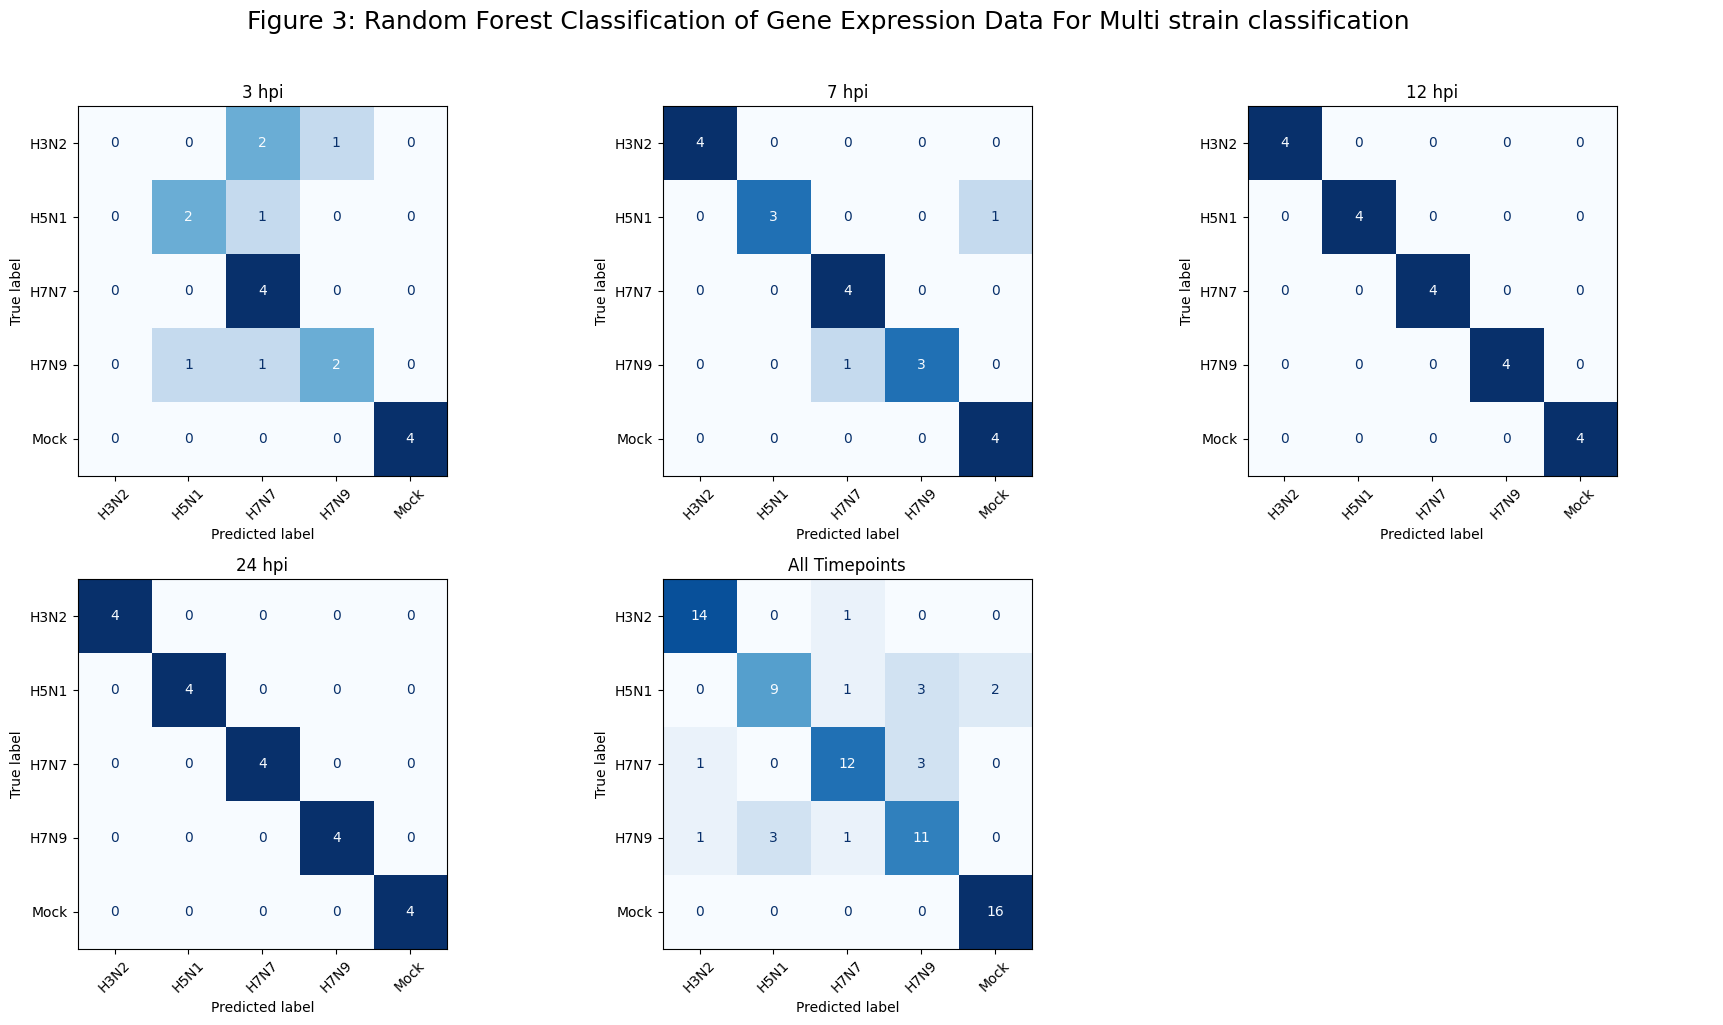

In [33]:
#Figure 3: Random Forest Classification of Gene Expression Data For Multi strain classification
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# === Load and clean data ===
df = pd.read_csv("C:/Users/DIR/Jupyter/Multi-strain classification/dataset-1/data.csv")
df["Time"] = df["Time"].str.extract(r"(\d+)").astype(int)
timepoints = sorted(df["Time"].unique())

# === Setup 2x3 plot panel ===
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

def get_valid_n_splits(y, max_splits=10):
    class_counts = Counter(y)
    min_class_size = min(class_counts.values())
    return max(2, min(max_splits, min_class_size))

# === Function to train RF and return confusion matrix ===
def train_and_plot_confusion(ax, X, y, title):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    label_names = label_encoder.classes_
    
    X_scaled = StandardScaler().fit_transform(X)
    
    n_splits = get_valid_n_splits(y)
    if n_splits < 2:
        ax.set_visible(False)
        return

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true, all_pred = [], []

    for train_idx, test_idx in skf.split(X_scaled, y_encoded):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_true.extend(y_test)
        all_pred.extend(y_pred)

    cm = confusion_matrix(all_true, all_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    ax.set_title(title)

# === 1. Plot each timepoint individually ===
for i, timepoint in enumerate(timepoints):
    subset = df[df["Time"] == timepoint]
    if subset.shape[0] < 2:
        axs[i].set_visible(False)
        continue

    X = subset.drop(columns=["Sample", "Virus_Strain", "Time"])
    y = subset["Virus_Strain"]
    train_and_plot_confusion(axs[i], X, y, f"{timepoint} hpi")

# === 2. Aggregated confusion matrix ===
X_all = df.drop(columns=["Sample", "Virus_Strain", "Time"])
y_all = df["Virus_Strain"]
train_and_plot_confusion(axs[4], X_all, y_all, "All Timepoints")

# === Hide any unused subplots (like panel 5) ===
for j in range(5, len(axs)):
    axs[j].axis("off")

plt.suptitle("Figure 3: Random Forest Classification of Gene Expression Data For Multi strain classification", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
#Figure 4: Random Forest Classification of Gene Expression Data for Binary Classification of Uninfected versus Infected
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# === Load and clean data ===
df = pd.read_csv("C:/Users/DIR/Jupyter/Multi-strain classification/dataset-1/data.csv")
df["Time"] = df["Time"].str.extract(r"(\d+)").astype(int)

# Create binary infection status: 'Mock' = Uninfected, else Infected
df["Infection_Status"] = df["Virus_Strain"].apply(lambda x: "Uninfected" if x.strip().lower() == "mock" else "Infected")

# Get all unique timepoints
timepoints = sorted(df["Time"].unique())

# === Set up 2x3 plot panel (for 4 timepoints + 1 aggregated) ===
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

# === Helper to determine valid n_splits based on smallest class ===
def get_valid_n_splits(y, max_splits=10):
    class_counts = Counter(y)
    return max(2, min(min(class_counts.values()), max_splits))

# === Function to train and plot confusion matrix ===
def train_and_plot_binary_confusion(ax, X, y, title):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    label_names = label_encoder.classes_

    X_scaled = StandardScaler().fit_transform(X)

    n_splits = get_valid_n_splits(y)
    if n_splits < 2:
        ax.set_visible(False)
        return

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_true, all_pred = [], []

    for train_idx, test_idx in skf.split(X_scaled, y_encoded):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]

        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        all_true.extend(y_test)
        all_pred.extend(y_pred)

    cm = confusion_matrix(all_true, all_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    ax.set_title(title)

# === 1. Plot individual confusion matrices per timepoint ===
for i, timepoint in enumerate(timepoints):
    subset = df[df["Time"] == timepoint]
    if subset.shape[0] < 2:
        axs[i].set_visible(False)
        continue

    y = subset["Infection_Status"]
    X = subset.drop(columns=["Sample", "Virus_Strain", "Time", "Infection_Status"])

    train_and_plot_binary_confusion(axs[i], X, y, f"{timepoint} hpi")

# === 2. Plot the aggregated confusion matrix ===
y_all = df["Infection_Status"]
X_all = df.drop(columns=["Sample", "Virus_Strain", "Time", "Infection_Status"])
train_and_plot_binary_confusion(axs[4], X_all, y_all, "All Timepoints")

# Hide last panel if unused
for j in range(5, len(axs)):
    axs[j].axis("off")

# Final formatting
plt.suptitle("Figure 4: Random Forest Classification of Gene Expression Data for Binary Classification of Uninfected versus Infected", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


'C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\\dendrogram_stats_purity_HPI12-24.csv'

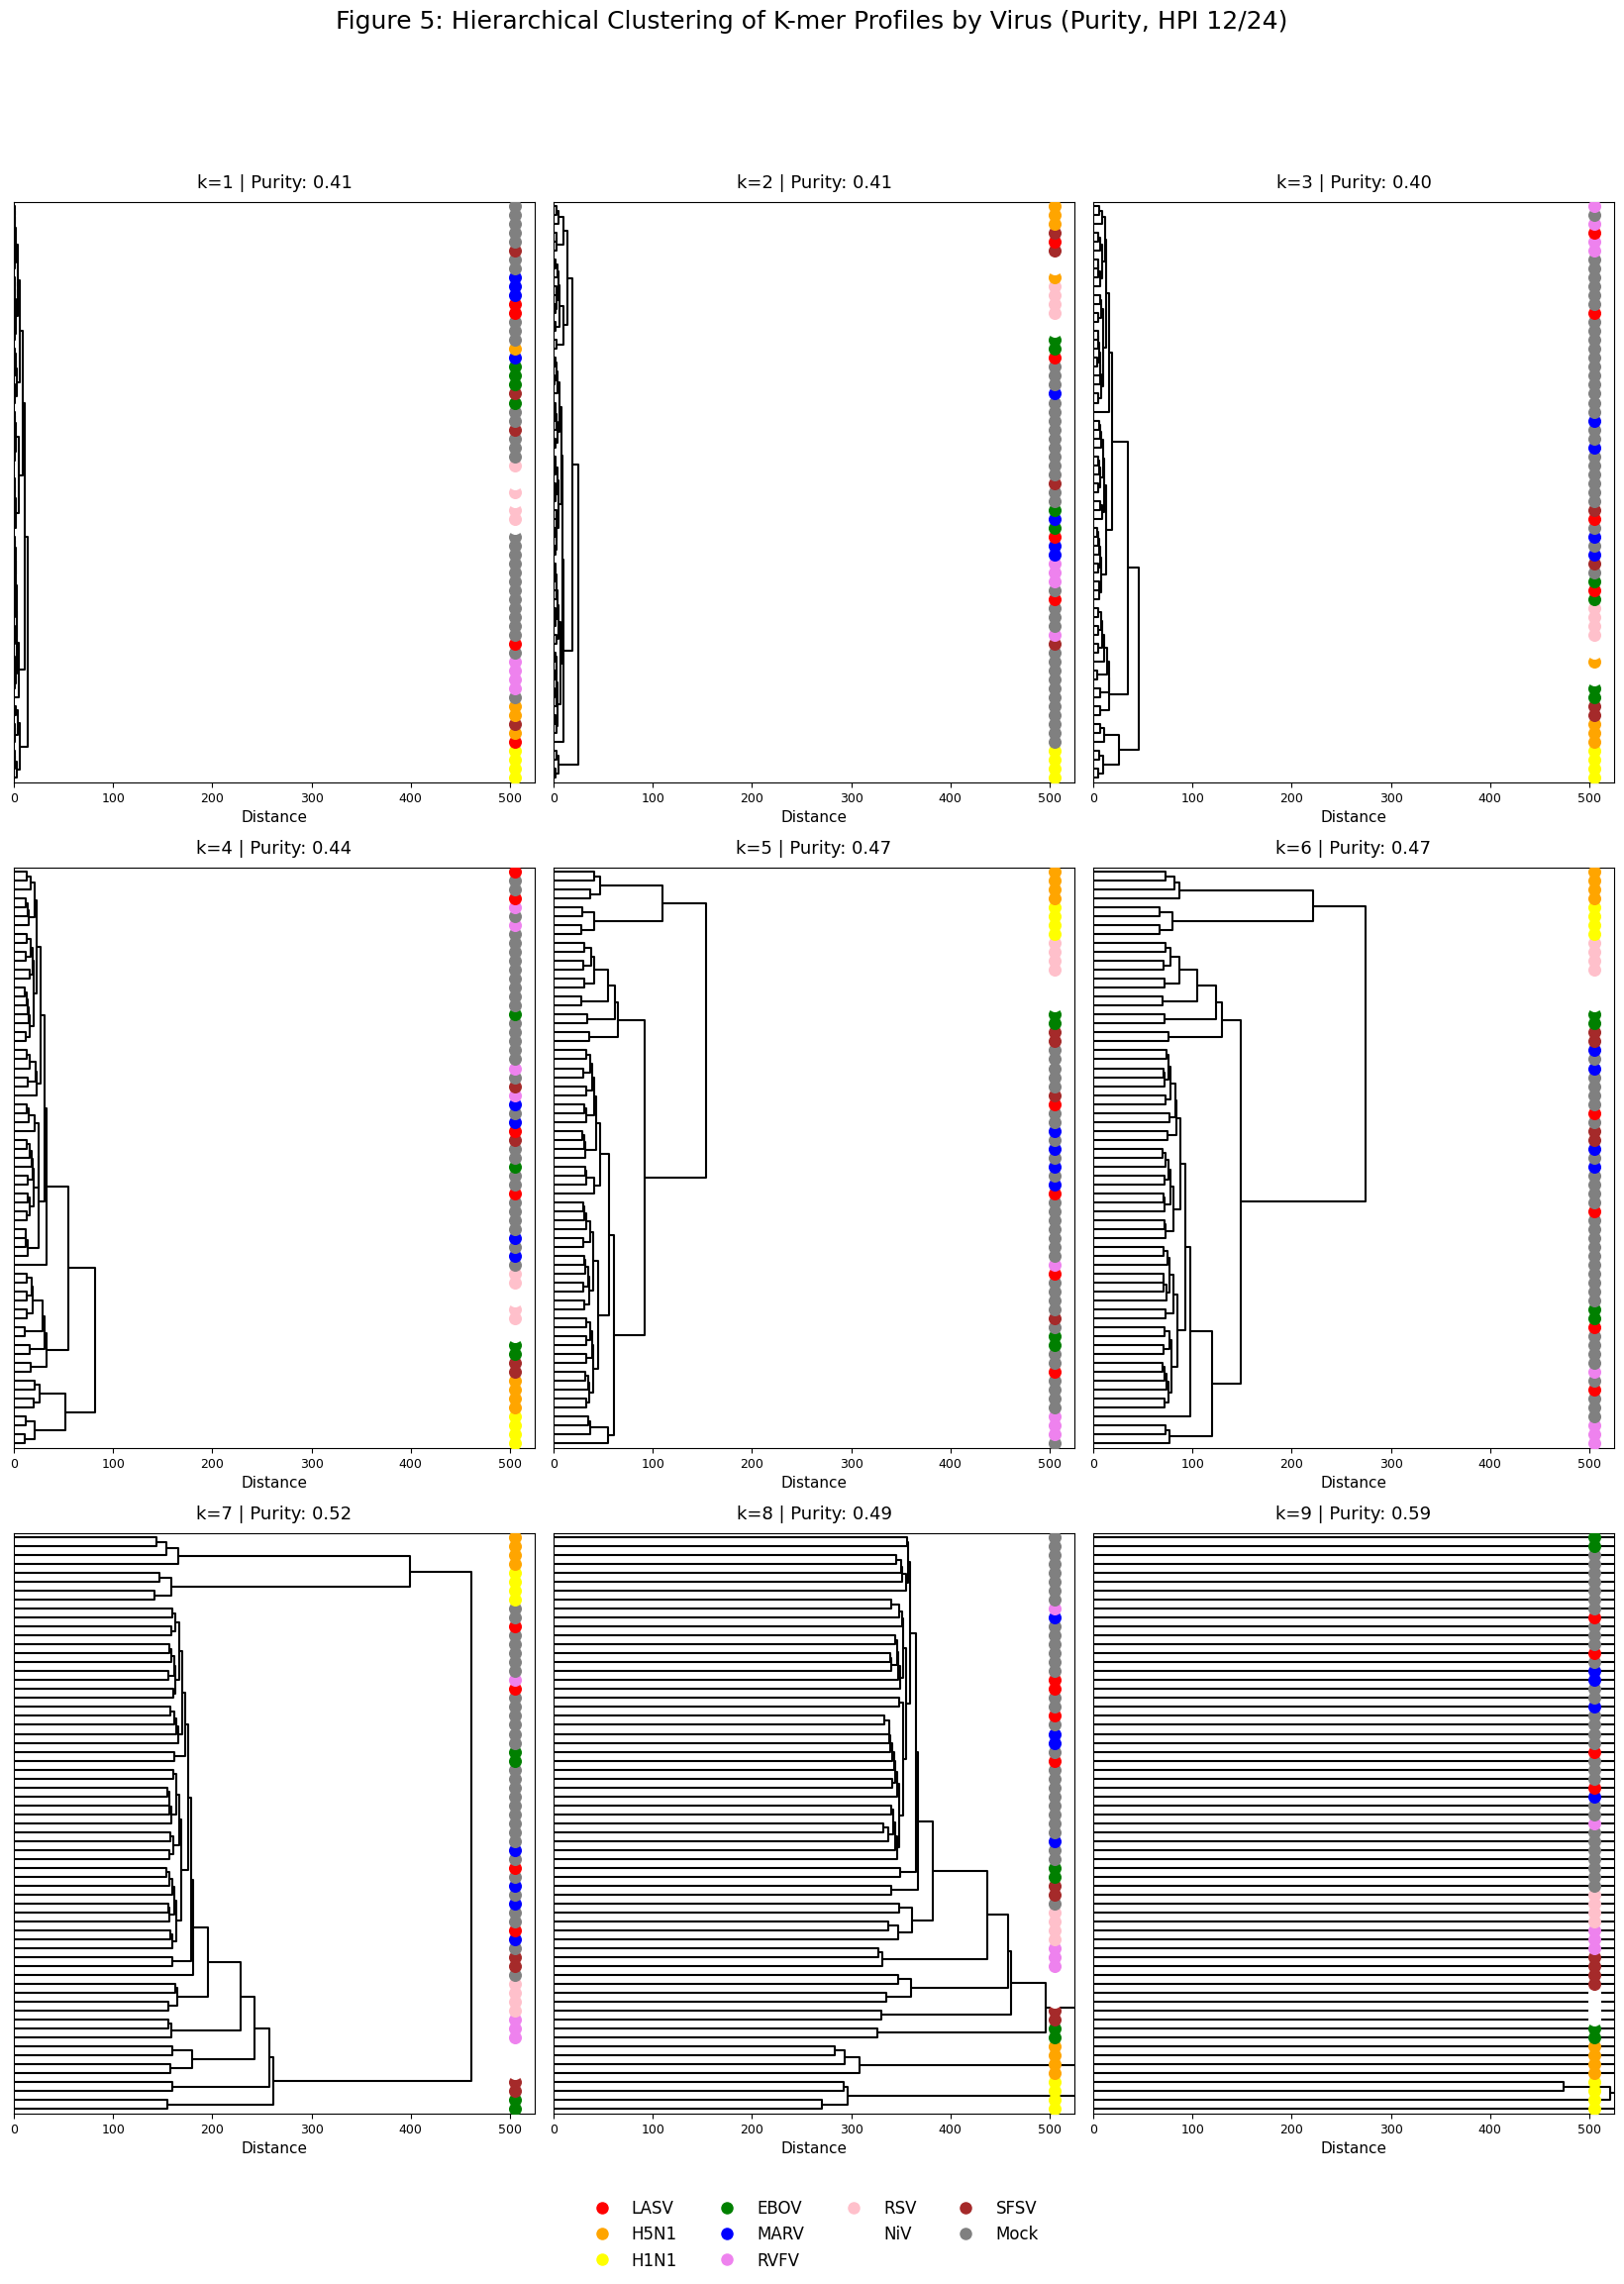

In [25]:
#Figure 5: Hierarchical Clustering of Kmer Abundance Profiles from Infected Cells
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from collections import defaultdict, Counter

# Parameters
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
strain_to_color = {
    'LASV': 'red', 'H5N1': 'orange', 'H1N1': 'yellow',
    'EBOV': 'green', 'MARV': 'blue', 'RVFV': 'violet',
    'RSV': 'pink', 'NiV': 'white', 'SFSV': 'brown', 'Mock': 'gray'
}
global_max_distance = 500

def compute_purity(linkage_matrix, labels):
    tree, _ = to_tree(linkage_matrix, rd=True)
    id_to_label = {i: labels[i] for i in range(len(labels))}
    label_to_indices = defaultdict(list)

    for i, label in enumerate(labels):
        label_to_indices[label].append(i)

    class_purities = {}

    for label, indices in label_to_indices.items():
        indices_set = set(indices)

        def find_subtree(node):
            if node.is_leaf():
                return node if node.id in indices_set else None
            left = find_subtree(node.left)
            right = find_subtree(node.right)
            if left and right:
                return node
            return left or right

        subtree = find_subtree(tree)
        if subtree:
            leaf_ids = subtree.pre_order()
            all_labels = [id_to_label[i] for i in leaf_ids]
            counts = Counter(all_labels)
            purity = counts[label] / len(all_labels)
            class_purities[label] = round(purity, 4)
        else:
            class_purities[label] = 0.0

    return class_purities

# Load and analyze files
csv_files = [f for f in sorted(os.listdir(kmer_csv_dir)) if f.endswith("_results_unfiltered.csv")]
n = len(csv_files)
cols = 3
rows = int(np.ceil(n / cols))

fig, axs = plt.subplots(rows, cols, figsize=(cols * 5.5, rows * 7.5))
axs = axs.flatten()
stats = []

for i, filename in enumerate(csv_files):
    file_path = os.path.join(kmer_csv_dir, filename)
    df = pd.read_csv(file_path)

    if "Virus" not in df.columns or "HPI" not in df.columns:
        axs[i].set_visible(False)
        continue

    df = df[~df["HPI"].isin([3, 6])]

    if df.empty:
        axs[i].set_visible(False)
        continue

    k = ''.join([c for c in filename if c.isdigit()]) or '?'
    labels = df["Virus"].values
    excluded_columns = ["Accession", "Filter", "Virus", "HPI"]
    feature_cols = [col for col in df.columns if col not in excluded_columns]
    features = df[feature_cols]

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)
    dist_matrix = pdist(scaled_data)
    linkage_matrix = linkage(scaled_data, method='ward')

    purity_scores = compute_purity(linkage_matrix, labels)
    mean_purity = np.mean(list(purity_scores.values()))

    stats.append({
        "k": k,
        "Filename": filename,
        "Num_Samples": len(df),
        "Num_Kmers": len(feature_cols),
        "Mean_Purity": round(mean_purity, 4),
        "Tree_Max_Height": round(np.max(linkage_matrix[:, 2]), 4),
        **{f"Purity_{lab}": score for lab, score in purity_scores.items()}
    })

    ax = axs[i]
    ddata = dendrogram(
        linkage_matrix,
        labels=None,
        orientation='right',
        ax=ax,
        color_threshold=0,
        link_color_func=lambda _: 'black'
    )

    leaf_positions = ax.get_yaxis().get_majorticklocs()
    leaves = ddata['leaves']
    viruses = labels[leaves]

    for y, virus in zip(leaf_positions, viruses):
        ax.scatter(global_max_distance * 1.01, y, s=70,
                   color=strain_to_color.get(virus, 'black'),
                   zorder=3)

    ax.set_xlim([0, global_max_distance * 1.05])
    ax.set_title(f"k={k} | Purity: {mean_purity:.2f}", fontsize=13, pad=10)
    ax.set_xlabel("Distance", fontsize=11)
    ax.set_ylabel("")
    ax.set_yticks([])
    ax.tick_params(axis='x', labelsize=9)

# Clean up extra subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=strain,
           markerfacecolor=color, markersize=10)
    for strain, color in strain_to_color.items()
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=12, frameon=False)
fig.suptitle("Figure 5: Hierarchical Clustering of K-mer Profiles by Virus (Purity, HPI 12/24)", fontsize=18, y=1.02)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
fig.savefig(os.path.join(kmer_csv_dir, "all_kmer_dendrograms_purity_HPI12-24.png"), dpi=300, bbox_inches='tight')

# Save purity stats
stats_df = pd.DataFrame(stats)
stats_output_path = os.path.join(kmer_csv_dir, "dendrogram_stats_purity_HPI12-24.csv")
stats_df.to_csv(stats_output_path, index=False)

stats_output_path


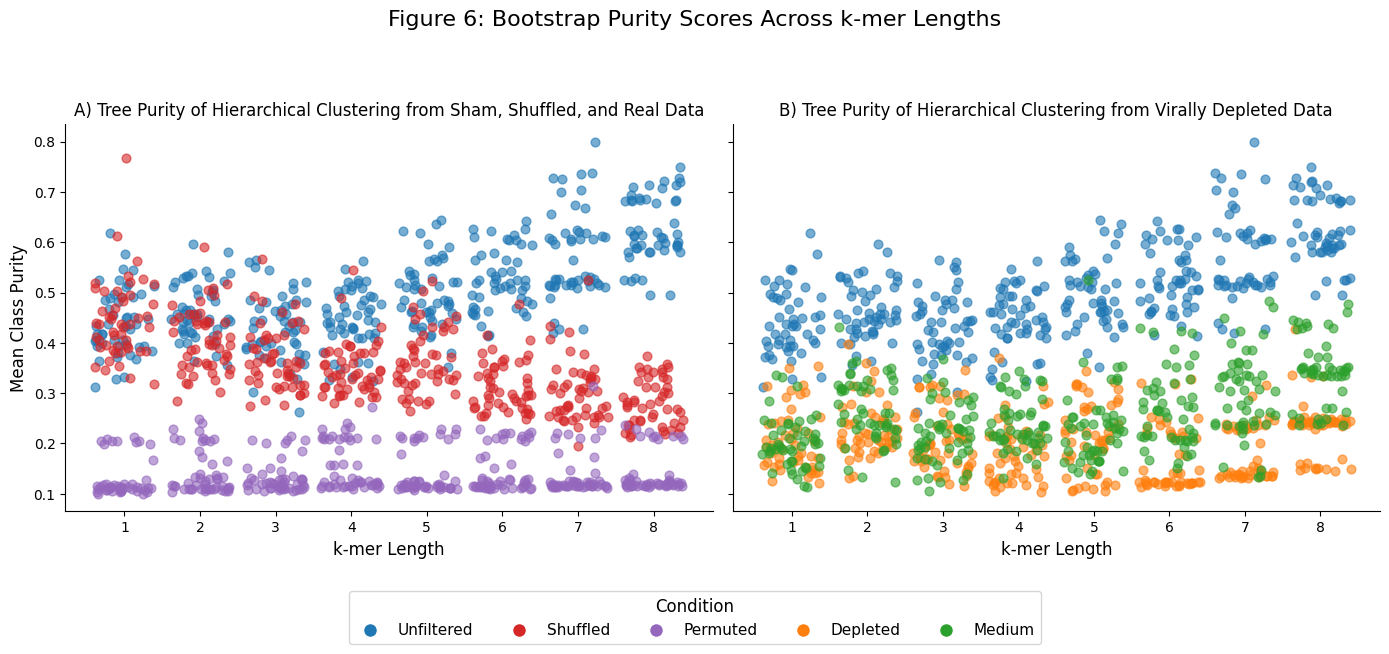

In [50]:
#Figure 6: Assessment of Hierarchical Clustering Efficiency of Variously Virally Depleted Data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from scipy.cluster.hierarchy import linkage, to_tree
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib.lines import Line2D


# PARAMETERS
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
kmer_range = range(1, 9)
bootstrap_iterations = 50
bootstrap_fraction = 0.8
datasets = {
    "Unfiltered": "_results_unfiltered.csv",
    "Depleted": "_results_high.csv",
    "Medium": "_results_medium.csv",
    "Shuffled": "_results_unfiltered_shuffled.csv",
    "Permuted": "_results_unfiltered_label_permuted.csv"
}

# Purity calculation
def compute_purity(linkage_matrix, labels):
    tree, _ = to_tree(linkage_matrix, rd=True)
    id_to_label = {i: labels[i] for i in range(len(labels))}
    label_to_indices = defaultdict(list)
    for i, label in enumerate(labels):
        label_to_indices[label].append(i)

    class_purities = {}
    for label, indices in label_to_indices.items():
        indices_set = set(indices)

        def find_subtree(node):
            if node.is_leaf():
                return node if node.id in indices_set else None
            left = find_subtree(node.left)
            right = find_subtree(node.right)
            if left and right:
                return node
            return left or right

        subtree = find_subtree(tree)
        if subtree:
            leaf_ids = subtree.pre_order()
            all_labels = [id_to_label[i] for i in leaf_ids]
            counts = Counter(all_labels)
            purity = counts[label] / len(all_labels)
            class_purities[label] = round(purity, 4)
        else:
            class_purities[label] = 0.0

    return np.mean(list(class_purities.values()))

# BOOTSTRAP LOOP
all_results = []

for condition, suffix in datasets.items():
    for k in kmer_range:
        file_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer{suffix}")
        if not os.path.exists(file_path):
            print(f"Skipping {file_path} (not found)")
            continue

        df = pd.read_csv(file_path)
        if "Virus" not in df.columns or "HPI" not in df.columns:
            continue

        df = df[~df["HPI"].isin([3, 6])]
        if df.empty:
            continue

        excluded_cols = ["Accession", "Filter", "Virus", "HPI"]
        feature_cols = [col for col in df.columns if col not in excluded_cols]
        X = df[feature_cols].values
        y = df["Virus"].values

        for iteration in range(bootstrap_iterations):
            sample_size = int(bootstrap_fraction * len(df))
            indices = np.random.choice(len(df), size=sample_size, replace=False)
            X_sub = X[indices]
            y_sub = y[indices]

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_sub)
            dist_matrix = pdist(X_scaled)
            linkage_matrix = linkage(X_scaled, method='ward')

            purity = compute_purity(linkage_matrix, y_sub)

            all_results.append({
                "Condition": condition,
                "k": k,
                "Iteration": iteration + 1,
                "Purity": purity
            })

# Save stats
results_df = pd.DataFrame(all_results)
results_path = os.path.join(kmer_csv_dir, "bootstrap_purity_scores_all_conditions.csv")
results_df.to_csv(results_path, index=False)

# PLOT
import seaborn as sns

# Optional: for consistent coloring across datasets
palette = {
    "Unfiltered": "#1f77b4", 
    "Shuffled": "#d62728", 
    "Permuted": "#9467bd",
    "Depleted": "#ff7f0e", 
    "Medium": "#2ca02c"
}

# Split dataset groups
panel1_conditions = ["Unfiltered", "Shuffled", "Permuted"]
panel2_conditions = ["Unfiltered", "Depleted", "Medium"]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot Panel 1
ax1 = axs[0]
for i, condition in enumerate(panel1_conditions):
    subset = results_df[results_df["Condition"] == condition]
    jittered_k = subset["k"] + (np.random.rand(len(subset)) - 0.5) * 0.8
    ax1.scatter(jittered_k, subset["Purity"], label=condition, alpha=0.6, s=40,
                color=palette.get(condition, None))
ax1.set_title("A) Tree Purity of Hierarchical Clustering from Sham, Shuffled, and Real Data", fontsize=12)
ax1.set_xlabel("k-mer Length", fontsize=12)
ax1.set_ylabel("Mean Class Purity", fontsize=12)
ax1.set_xticks(sorted(results_df["k"].unique()))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(False)

# Plot Panel 2
ax2 = axs[1]
for i, condition in enumerate(panel2_conditions):
    subset = results_df[results_df["Condition"] == condition]
    jittered_k = subset["k"] + (np.random.rand(len(subset)) - 0.5) * 0.8
    ax2.scatter(jittered_k, subset["Purity"], label=condition, alpha=0.6, s=40,
                color=palette.get(condition, None))
ax2.set_title("B) Tree Purity of Hierarchical Clustering from Virally Depleted Data", fontsize=12)
ax2.set_xlabel("k-mer Length", fontsize=12)
ax2.set_xticks(sorted(results_df["k"].unique()))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(False)
handles, labels = ax2.get_legend_handles_labels()

#Legend
# Full list of all conditions used across both panels
all_conditions = ["Unfiltered", "Shuffled", "Permuted", "Depleted", "Medium"]

# Create colored marker handles
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=cond,
           markerfacecolor=palette[cond], markersize=10)
    for cond in all_conditions
]

# Add shared legend at bottom
fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=len(all_conditions),
    fontsize=11,
    title="Condition",
    title_fontsize=12,
    bbox_to_anchor=(0.5, -0.05)
)

# Title
fig.suptitle("Figure 6: Bootstrap Purity Scores Across k-mer Lengths", fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # leave space at bottom

# Save + show
plot_path = os.path.join(kmer_csv_dir, "bootstrap_purity_plot_dual_panels.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

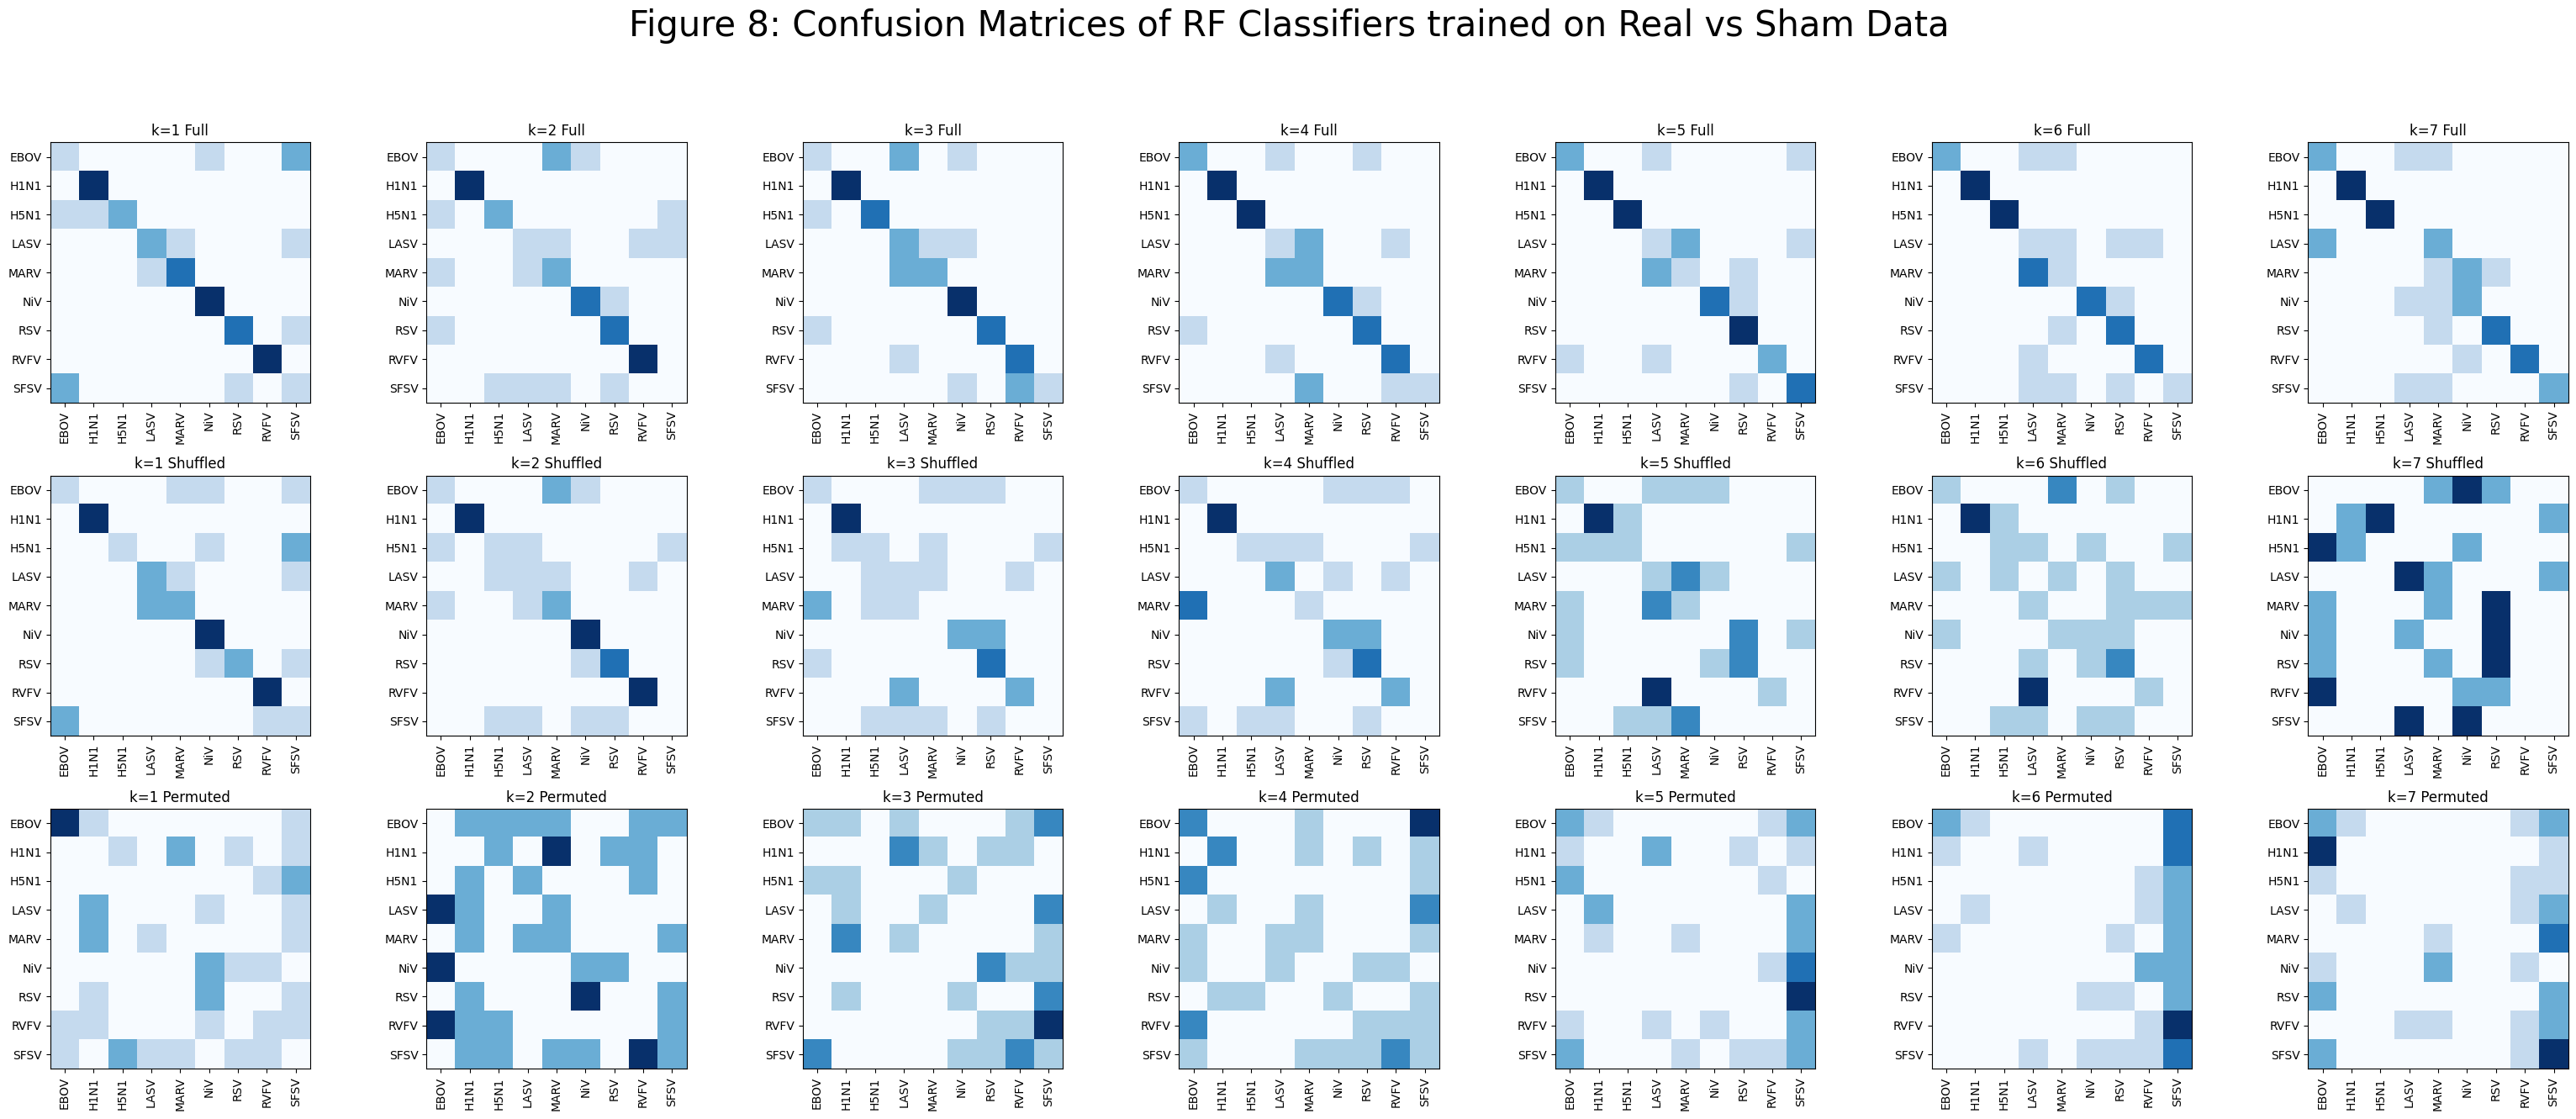

('C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\\fig8.png',
 'C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\\cm_data_fig8.csv')

In [23]:
#Figure 8: Confusion Matrices of RF trained on kmer data vs shuffled vs permuted
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Parameters
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
k_range = range(1, 8)
results = []

def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[
        (df["Virus"] != "Mock") &
        (df["HPI"] != 3) &
        (df["HPI"] != 6)
    ]
    excluded_cols = ["Accession", "Filter", "Virus", "HPI"]
    feature_cols = [c for c in df.columns if c not in excluded_cols]
    X = df[feature_cols].values
    y = df["Virus"].values
    return X, y, sorted(np.unique(y))

def run_rf_cv(X, y, class_labels, k, condition):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    agg_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)
    all_y_true = []
    all_y_pred = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        agg_cm += cm
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    overall_acc = accuracy_score(all_y_true, all_y_pred)
    report = classification_report(all_y_true, all_y_pred, output_dict=True, labels=class_labels)
    df_report = pd.DataFrame(report).T.reset_index()
    df_report['k'] = k
    df_report['Condition'] = condition
    df_report['Overall_Accuracy'] = overall_acc

    return df_report, agg_cm, class_labels

# Set up figure
# Set up figure
fig, axs = plt.subplots(3, len(k_range), figsize=(4.5 * len(k_range), 13))
axs = axs.reshape(3, len(k_range))

for col_idx, k in enumerate(k_range):
    full_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_unfiltered.csv")
    shuffled_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_unfiltered_shuffled.csv")
    permuted_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_unfiltered_label_permuted.csv")

    if not all(os.path.exists(p) for p in [full_path, shuffled_path, permuted_path]):
        for row in range(4):
            axs[row, col_idx].axis('off')
        continue

    X_full, y_full, labels = load_data(full_path)
    X_shuffled, y_shuffled, _ = load_data(shuffled_path)
    X_permuted, y_permuted, _ = load_data(permuted_path)

    df_full, cm_full, lbls = run_rf_cv(X_full, y_full, labels, k, "Full")
    df_shuffled, cm_shuffled, _ = run_rf_cv(X_shuffled, y_shuffled, labels, k, "Shuffled")
    df_permuted, cm_permuted, _ = run_rf_cv(X_permuted, y_permuted, labels, k, "Permuted")

    results.extend([df_full, df_medium, df_depleted, df_shuffled, df_permuted])

    for row_idx, (cm, condition) in enumerate(zip([cm_full, cm_shuffled, cm_permuted], ["Full", "Shuffled", "Permuted"])):
        ax = axs[row_idx, col_idx]
        ax.imshow(cm, cmap='Blues')
        ax.set_title(f"k={k} {condition}")
        ax.set_xticks(np.arange(len(lbls)))
        ax.set_yticks(np.arange(len(lbls)))
        ax.set_xticklabels(lbls, rotation=90)
        ax.set_yticklabels(lbls)

fig.suptitle("Figure 8: Confusion Matrices of RF Classifiers trained on Real vs Sham Data", fontsize=30, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leaves space at the top for the suptitle
fig_path = os.path.join(kmer_csv_dir, "fig8.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

# Save results
final_stats = pd.concat(results, ignore_index=True)
stats_path = os.path.join(kmer_csv_dir, "cm_data_fig8.csv")
#final_stats.to_csv(stats_path, index=False)

fig_path, stats_path

Figure 8: RF classifiers trained on the permuted data were unable to learn the differences between each class, indicating that the model is not overfitting on this dataset. RF classifiers trained on data where the nucleotides were shuffled between reads were still able to classify viruses accurately but at lower kmer lengths.

C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

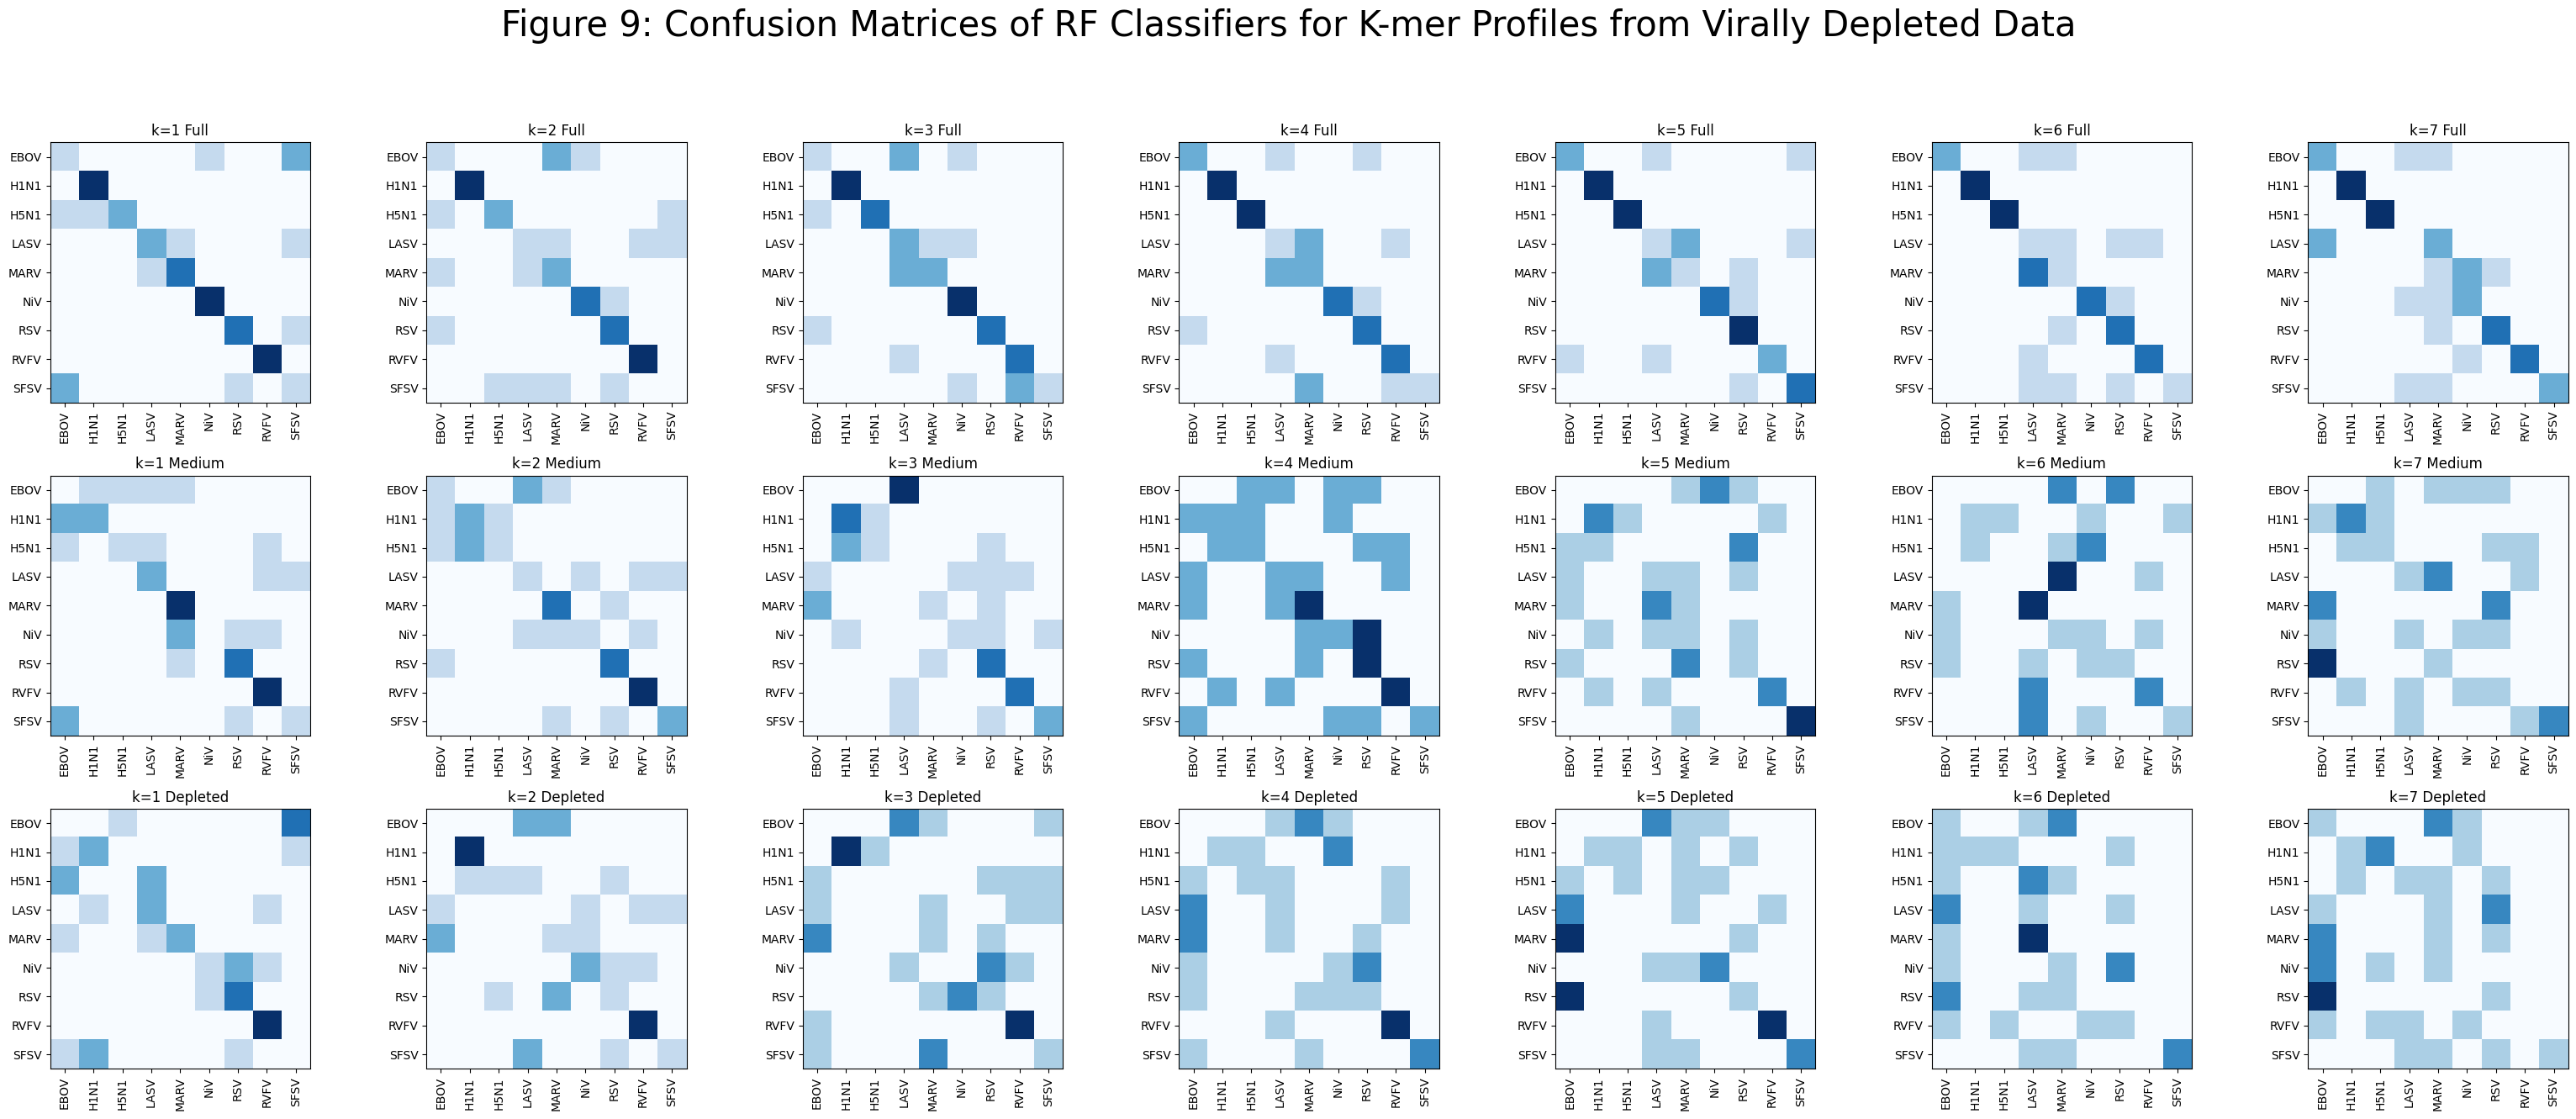

('C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\\fig9.png',
 'C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables\\cm_data_fig9.csv')

In [24]:
#Figure 9: Confusion Matrices of RF trained on kmer data vs depleted data
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Parameters
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
k_range = range(1, 8)
results = []

def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df[
        (df["Virus"] != "Mock") &
        (df["HPI"] != 3) &
        (df["HPI"] != 6)
    ]
    excluded_cols = ["Accession", "Filter", "Virus", "HPI"]
    feature_cols = [c for c in df.columns if c not in excluded_cols]
    X = df[feature_cols].values
    y = df["Virus"].values
    return X, y, sorted(np.unique(y))

def run_rf_cv(X, y, class_labels, k, condition):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    agg_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)
    all_y_true = []
    all_y_pred = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        agg_cm += cm
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    overall_acc = accuracy_score(all_y_true, all_y_pred)
    report = classification_report(all_y_true, all_y_pred, output_dict=True, labels=class_labels)
    df_report = pd.DataFrame(report).T.reset_index()
    df_report['k'] = k
    df_report['Condition'] = condition
    df_report['Overall_Accuracy'] = overall_acc

    return df_report, agg_cm, class_labels

# Set up figure
fig, axs = plt.subplots(3, len(k_range), figsize=(4.5 * len(k_range), 13))
axs = axs.reshape(3, len(k_range))

for col_idx, k in enumerate(k_range):
    full_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_unfiltered.csv")
    medium_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_medium.csv")
    depleted_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_high.csv")


    if not all(os.path.exists(p) for p in [full_path, medium_path, depleted_path]):
        for row in range(4):
            axs[row, col_idx].axis('off')
        continue

    X_full, y_full, labels = load_data(full_path)
    X_medium, y_medium, _ = load_data(medium_path)
    X_depleted, y_depleted, _ = load_data(depleted_path)

    df_full, cm_full, lbls = run_rf_cv(X_full, y_full, labels, k, "Full")
    df_medium, cm_medium, _ = run_rf_cv(X_medium, y_medium, labels, k, "Medium")
    df_depleted, cm_depleted, _ = run_rf_cv(X_depleted, y_depleted, labels, k, "Depleted")

    results.extend([df_full, df_medium, df_depleted])

    for row_idx, (cm, condition) in enumerate(zip([cm_full, cm_medium, cm_depleted], ["Full", "Medium", "Depleted"])):
        ax = axs[row_idx, col_idx]
        ax.imshow(cm, cmap='Blues')
        ax.set_title(f"k={k} {condition}")
        ax.set_xticks(np.arange(len(lbls)))
        ax.set_yticks(np.arange(len(lbls)))
        ax.set_xticklabels(lbls, rotation=90)
        ax.set_yticklabels(lbls)

fig.suptitle("Figure 9: Confusion Matrices of RF Classifiers for K-mer Profiles from Virally Depleted Data", fontsize=30, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leaves space at the top for the suptitle
fig_path = os.path.join(kmer_csv_dir, "fig9.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

# Save results
final_stats = pd.concat(results, ignore_index=True)
stats_path = os.path.join(kmer_csv_dir, "cm_data_fig9.csv")
#final_stats.to_csv(stats_path, index=False)

fig_path, stats_path

Figure 9: 3 reads from the raw .fastq files were aligned to a set of viral reference genomes to identify and remove the reads matching viral genomes. Two different stringency levels were used "medium" and "depleted" representing different depletion levels of viral reads. The RF classifiers trained on data with the original amount of viral reads present was the most learnable by the RF classifier.

C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DIR\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

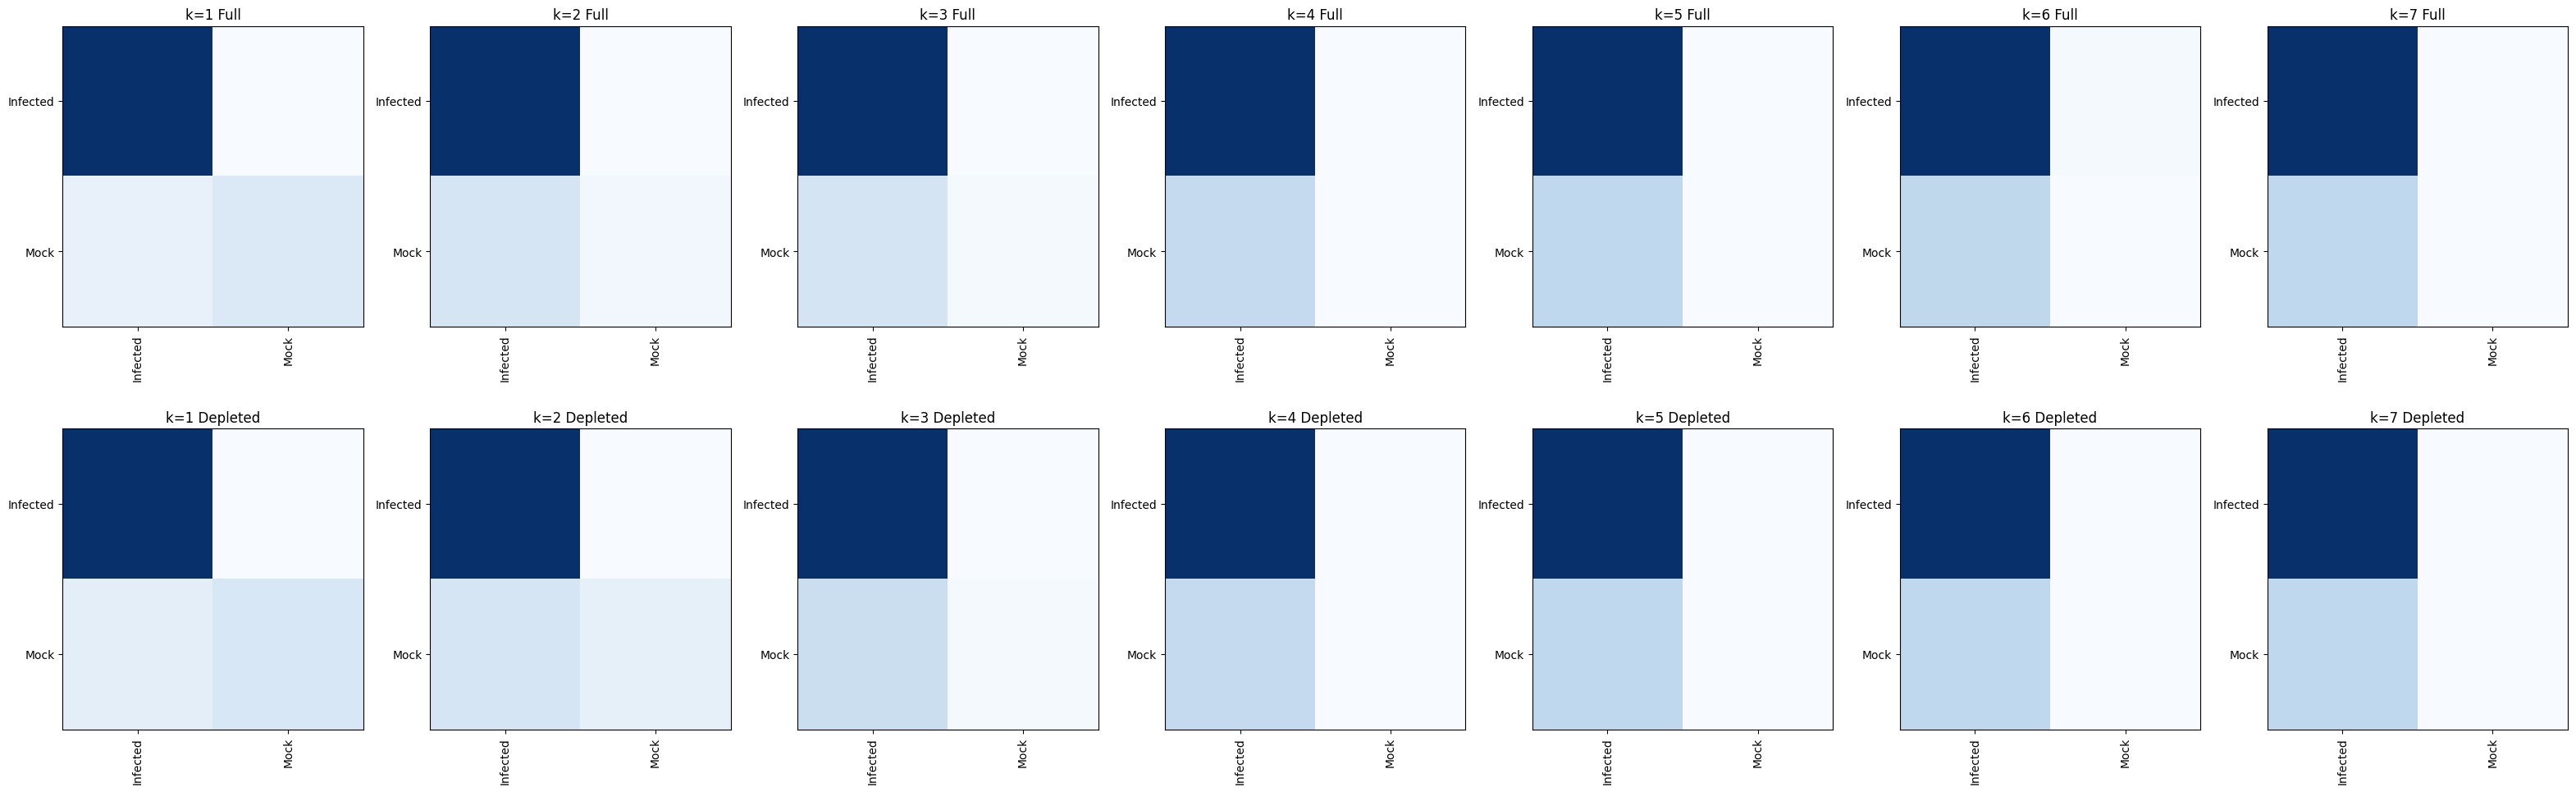

In [44]:
#Figure 10: Confusion Matrices of RF trained on kmer data from infected vs non-infected
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Parameters
kmer_csv_dir = "C:/Users/DIR/Jupyter/Multi-strain classification/dataset-2/kmer_tables"
k_range = range(1, 8)
results = []

def load_binary_data(file_path):
    df = pd.read_csv(file_path)
    df["Label"] = df["Virus"].apply(lambda x: "Mock" if x == "Mock" else "Infected")
    excluded_cols = ["Accession", "Filter", "Virus"]
    feature_cols = [c for c in df.columns if c not in excluded_cols + ["Label"]]
    X = df[feature_cols].values
    y = df["Label"].values
    return X, y, sorted(np.unique(y))

def run_rf_cv(X, y, class_labels, k, condition):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    agg_cm = np.zeros((len(class_labels), len(class_labels)), dtype=int)
    all_y_true = []
    all_y_pred = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=class_labels)
        agg_cm += cm
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

    overall_acc = accuracy_score(all_y_true, all_y_pred)
    report = classification_report(all_y_true, all_y_pred, output_dict=True, labels=class_labels)
    df_report = pd.DataFrame(report).T.reset_index()
    df_report['k'] = k
    df_report['Condition'] = condition
    df_report['Overall_Accuracy'] = overall_acc

    return df_report, agg_cm, class_labels

# Create plot
fig, axs = plt.subplots(2, len(k_range), figsize=(4.5 * len(k_range), 10))
axs = axs.flatten()

for i, k in enumerate(k_range):
    full_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_unfiltered.csv")
    depleted_path = os.path.join(kmer_csv_dir, f"multivirus_{k}mer_results_high.csv")

    if not os.path.exists(full_path) or not os.path.exists(depleted_path):
        continue

    X_full, y_full, labels = load_binary_data(full_path)
    X_depleted, y_depleted, _ = load_binary_data(depleted_path)

    df_full, cm_full, lbls = run_rf_cv(X_full, y_full, labels, k, "Full")
    df_depleted, cm_depleted, _ = run_rf_cv(X_depleted, y_depleted, labels, k, "Depleted")

    results.append(df_full)
    results.append(df_depleted)

    # Plot confusion matrices
    ax_f = axs[i]
    ax_d = axs[i + len(k_range)]
    ax_f.imshow(cm_full, cmap='Blues')
    ax_d.imshow(cm_depleted, cmap='Blues')
    ax_f.set_title(f"k={k} Full")
    ax_d.set_title(f"k={k} Depleted")

    for ax in (ax_f, ax_d):
        ax.set_xticks(np.arange(len(lbls)))
        ax.set_yticks(np.arange(len(lbls)))
        ax.set_xticklabels(lbls, rotation=90)
        ax.set_yticklabels(lbls)

plt.tight_layout()
fig_path = os.path.join(kmer_csv_dir, "rf_binary_mock_vs_infected_confusion_matrices_balanced.png")
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

# Save results
final_stats = pd.concat(results, ignore_index=True)
stats_path = os.path.join(kmer_csv_dir, "rf_binary_mock_vs_infected_stats_balanced.csv")
final_stats.to_csv(stats_path, index=False)
